In [1]:
# Global imports
import warnings

warnings.filterwarnings("ignore")

import re
import numpy as np
import pandas as pd
import seaborn as sn
from langdetect import detect
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
food_facts_data = pd.pandas.read_csv('en.openfoodfacts.org.products_latest.csv', sep='\t', parse_dates=True, low_memory=False)

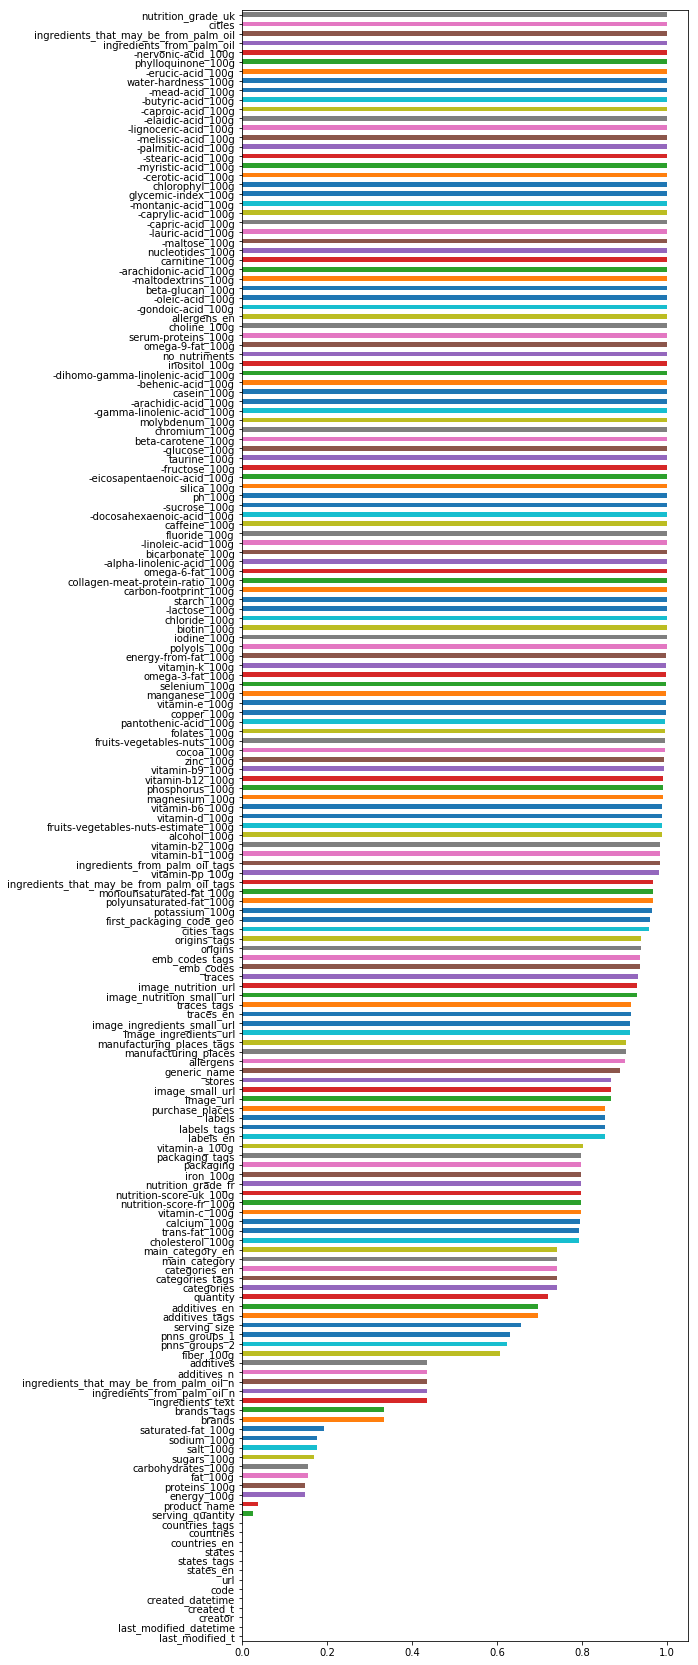

In [3]:
# There are a lot of NaN values in the dataset
food_facts_data.isnull().mean().sort_values(ascending=True).plot.barh(figsize = (8, 30))

### First idea
We are very curious in "Food carbon footprint": greenhouse gas emissions produced by growing, rearing, farming, processing, transporting, storing, cooking and disposing of the food we eat. We are interested in finding out the countries, which are emitting huge amount of carbon in the result of food production and consumption, and identify the ways to reduce it. We hope the dataset will give us insights about the products and their origins having highest carbon footprint(i.e. meat, cheese,eggs, so on) and the ones having lower carbon footprints(i.e. fruit, vegetables, beans, nuts so on). Additionally we consider that food packaging and food waste treatment have huge proportion of impact on carbon emission, thus these were hypothesis that we were interested to test and make conclusions about global problems.

In [4]:
# Number of food samples with valid carbon foot print is 344
CARBON_FOOD_PRINT_MASK = ~food_facts_data['carbon-footprint_100g'].isnull()
food_facts_data[CARBON_FOOD_PRINT_MASK].shape

(344, 173)

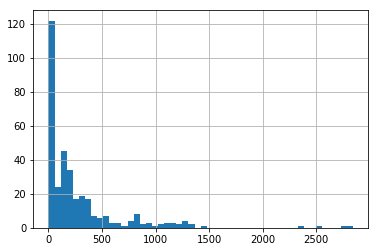

In [5]:
# Distribution of Carbon-foot-print.
food_facts_data['carbon-footprint_100g'].hist(bins=50)

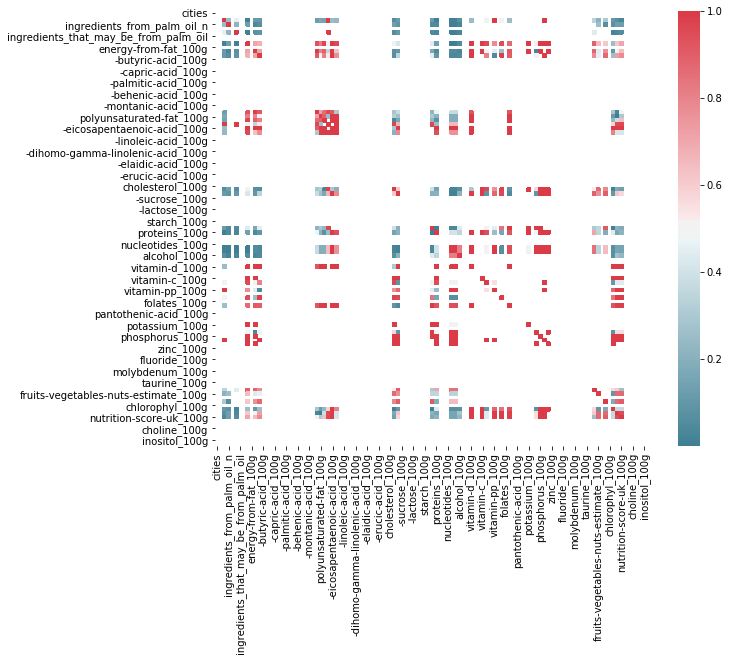

In [6]:
numeric_columns = food_facts_data.dtypes[food_facts_data.dtypes ==  'float64'].index

# Plotting the correlation matrix for carbon food print
corr_ = food_facts_data[CARBON_FOOD_PRINT_MASK][numeric_columns].corr().abs()
fig, axis = plt.subplots(figsize=(10, 8))
sn.heatmap(corr_, mask=np.zeros_like(corr_, dtype=np.bool), cmap=sn.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=axis)

In [7]:
## Sort the features having highest correlation with carbon footprint
valid_corr_columns = corr_['carbon-footprint_100g'].dropna().sort_values(ascending=False)
valid_corr_columns = valid_corr_columns[valid_corr_columns > 0.4]

In [8]:
# Checking out number of data samples with high-correlation with other non-numeric columns.
food_facts_data[food_facts_data['carbon-footprint_100g'].notnull()][valid_corr_columns.index].notnull().sum()

-eicosapentaenoic-acid_100g      5
phosphorus_100g                  2
carbon-footprint_100g          344
vitamin-c_100g                   2
magnesium_100g                   2
iron_100g                        2
vitamin-d_100g                   5
vitamin-b12_100g                 6
vitamin-pp_100g                  3
vitamin-b9_100g                  5
-docosahexaenoic-acid_100g       8
-alpha-linolenic-acid_100g       5
fruits-vegetables-nuts_100g      8
proteins_100g                  295
dtype: int64

## Conclusion

Unfortunately the high correlation is because of the lack of datapoints, it has been shown that the proportions of NAN is very high in the dataset where the carbon footprint has some information. So our thoughts that we may apply regression and other fill in tools to fill the carbon footprint values are ruined, we decided to leave this idea because we dont have enough data and didn't find the carbon footprint of each food product to make real conculsions. 

In [9]:
# Plotting distribution of Additives in the dataset
number_additives = food_facts_data[food_facts_data.additives_en.notnull()].additives_en.str.split(',').values.flatten()
number_additives = np.concatenate(number_additives)
number_additives = np.unique(number_additives, return_counts=True)
number_additives = pd.Series(number_additives[1], index=number_additives[0])

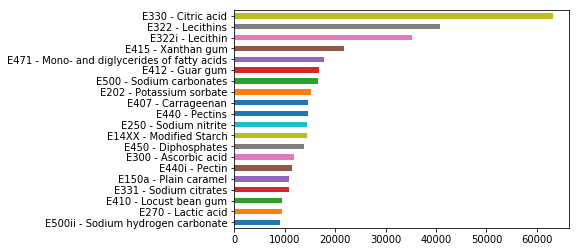

In [10]:
number_additives.sort_values()[-20:].plot.barh()

In [11]:
# According to the documentation of dataset each food item is assigned a unique code. So we can make code as the index of our
# data frame and relate all the other datasets on this index.
# However, we find that the code is not unique.
try:
    food_facts_data.set_index('code', inplace=True, drop=False)
except:
    print('code is already index')
    
food_facts_data.index.is_unique

False

In [12]:
# Lets investigate the data samples with the same bar code.
_not_unique = food_facts_data[['code']].groupby(food_facts_data.index).count() != 1
food_facts_data.loc[_not_unique[_not_unique.code].index].head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
code,,,,,,,,,,,,,,,,,,,,,
0055577102152,0055577102152,http://world-en.openfoodfacts.org/product/0055...,openfoodfacts-contributors,1539826478,2018-10-18T01:34:38Z,1539976159,2018-10-19T19:09:19Z,Gruau rapide /Quick Oats,NaN,350 g 12 sachets / packets,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0055577102152,0055577102152,http://world-en.openfoodfacts.org/product/0055...,openfoodfacts-contributors,1539826478,2018-10-18T01:34:38Z,1539976159,2018-10-19T19:09:19Z,Gruau rapide /Quick Oats,NaN,350 g 12 sachets / packets,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0067275001132,0067275001132,http://world-en.openfoodfacts.org/product/0067...,openfoodfacts-contributors,1537620864,2018-09-22T12:54:24Z,1541795512,2018-11-09T20:31:52Z,tartinade suprême raisin,NaN,235 ml,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0067275001132,0067275001132,http://world-en.openfoodfacts.org/product/0067...,openfoodfacts-contributors,1537620864,2018-09-22T12:54:24Z,1542134407,2018-11-13T18:40:07Z,tartinade suprême raisin,NaN,235 ml,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0070177029623,0070177029623,http://world-en.openfoodfacts.org/product/0070...,openfoodfacts-contributors,1402000298,2014-06-05T20:31:38Z,1541702949,2018-11-08T18:49:09Z,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# We see that the data contains duplicate values for all columns, except for last_modified time. Since the food product is
# same we pick the latest samples.
food_facts_data.drop(columns=['code'], inplace=True)
food_facts_data = food_facts_data.groupby(food_facts_data.index).head(1)

In [14]:
print("Is index unique: {}".format(food_facts_data.index.is_unique))
print("Number of na index: {}".format(food_facts_data.index.isna().sum()))

Is index unique: True
Number of na index: 1


In [15]:
# Remove the na code food item as the data is corrupted
food_facts_data = food_facts_data.drop(np.nan)

In [16]:
print("Number of na index: {}".format(food_facts_data.index.isna().sum()))

Number of na index: 0


In [17]:
# We first analyse the nutritional facts of all the available products. So we keep columns 'product_name', 'categories'
# and all nutrition features (number of features: 85)

NUTRIENTS_ALL = [
       'energy_100g', 'energy-from-fat_100g', 'fat_100g',
       'saturated-fat_100g', '-butyric-acid_100g', '-caproic-acid_100g',
       '-caprylic-acid_100g', '-capric-acid_100g', '-lauric-acid_100g',
       '-myristic-acid_100g', '-palmitic-acid_100g', '-stearic-acid_100g',
       '-arachidic-acid_100g', '-behenic-acid_100g',
       '-lignoceric-acid_100g', '-cerotic-acid_100g',
       '-montanic-acid_100g', '-melissic-acid_100g',
       'monounsaturated-fat_100g', 'polyunsaturated-fat_100g',
       'omega-3-fat_100g', '-alpha-linolenic-acid_100g',
       '-eicosapentaenoic-acid_100g', '-docosahexaenoic-acid_100g',
       'omega-6-fat_100g', '-linoleic-acid_100g',
       '-arachidonic-acid_100g', '-gamma-linolenic-acid_100g',
       '-dihomo-gamma-linolenic-acid_100g', 'omega-9-fat_100g',
       '-oleic-acid_100g', '-elaidic-acid_100g', '-gondoic-acid_100g',
       '-mead-acid_100g', '-erucic-acid_100g', '-nervonic-acid_100g',
       'trans-fat_100g', 'cholesterol_100g', 'carbohydrates_100g',
       'sugars_100g', '-sucrose_100g', '-glucose_100g', '-fructose_100g',
       '-lactose_100g', '-maltose_100g', '-maltodextrins_100g',
       'starch_100g', 'polyols_100g', 'fiber_100g', 'proteins_100g',
       'casein_100g', 'serum-proteins_100g', 'nucleotides_100g',
       'salt_100g', 'sodium_100g', 'alcohol_100g', 'vitamin-a_100g',
       'beta-carotene_100g', 'vitamin-d_100g', 'vitamin-e_100g',
       'vitamin-k_100g', 'vitamin-c_100g', 'vitamin-b1_100g',
       'vitamin-b2_100g', 'vitamin-pp_100g', 'vitamin-b6_100g',
       'vitamin-b9_100g', 'folates_100g', 'vitamin-b12_100g',
       'biotin_100g', 'pantothenic-acid_100g', 'silica_100g',
       'bicarbonate_100g', 'potassium_100g', 'chloride_100g',
       'calcium_100g', 'phosphorus_100g', 'iron_100g', 'magnesium_100g',
       'zinc_100g', 'copper_100g', 'manganese_100g', 'fluoride_100g',
       'selenium_100g', 'chromium_100g', 'molybdenum_100g', 'iodine_100g',
       'caffeine_100g', 'taurine_100g', 'ph_100g']

In [18]:
nutrition_facts = food_facts_data[NUTRIENTS_ALL]

In [19]:
nutrition_facts.describe()

,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,-butyric-acid_100g,-caproic-acid_100g,-caprylic-acid_100g,-capric-acid_100g,-lauric-acid_100g,-myristic-acid_100g,...,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g
count,5.959940e+05,912.000000,590619.000000,564695.000000,1.0,1.0,3.000000,3.000000,7.000000,2.00000,...,2210.000000,1729.000000,173.000000,1260.000000,40.000000,38.000000,470.000000,168.000000,59.000000,114.000000
mean,1.177096e+03,561.764572,13.647006,5.356245,5.0,6.0,8.466667,22.360000,35.506390,14.45000,...,0.025066,0.007534,0.007521,0.015151,0.000859,0.000133,0.099622,4.384776,7.906895,6.636454
std,7.901666e+03,701.299208,111.909696,42.495587,NaN,NaN,2.203028,28.267522,21.397063,6.29325,...,0.892554,0.127787,0.047344,0.406391,0.004749,0.000608,1.477306,31.080653,52.122576,1.660240
min,0.000000e+00,0.000000,0.000000,0.000000,5.0,6.0,7.000000,5.880000,0.044730,10.00000,...,-6.896552,0.000000,0.000000,-0.000002,0.000002,0.000003,0.000000,0.000000,0.000720,0.000000
25%,4.180000e+02,43.800000,0.500000,0.100000,5.0,6.0,7.200000,6.040000,27.000000,12.22500,...,0.000175,0.000000,0.000020,0.000005,0.000010,0.000005,0.000015,0.020000,0.037500,6.225000
50%,1.096000e+03,292.500000,6.300000,1.800000,5.0,6.0,7.400000,6.200000,46.200000,14.45000,...,0.000417,0.001000,0.000100,0.000021,0.000014,0.000010,0.000034,0.032000,0.394000,7.200000
75%,1.674000e+03,879.750000,21.000000,7.300000,5.0,6.0,9.200000,30.600000,49.150000,16.67500,...,0.001000,0.002000,0.000500,0.000054,0.000043,0.000039,0.000089,0.053575,0.400000,7.500000
max,2.845810e+06,3830.000000,66700.000000,18000.000000,5.0,6.0,11.000000,55.000000,50.000000,18.90000,...,37.600000,4.000000,0.560000,13.900000,0.030000,0.003760,29.000000,333.000000,400.000000,8.400000


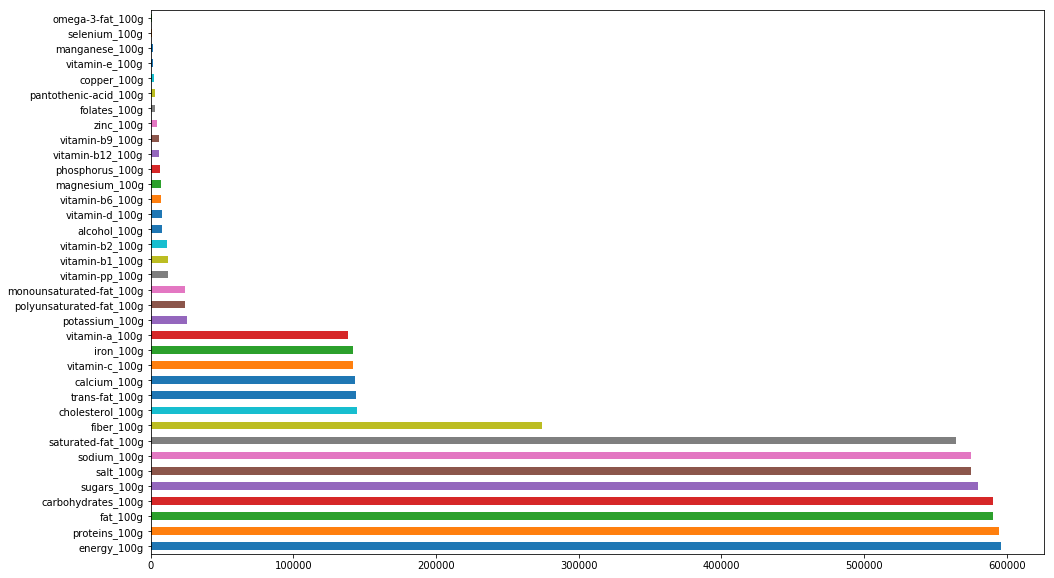

In [20]:
# We can observe that some nutrients have only very few data points. (For example -butyric-acid has only one data point)
# So, we keep only top KEEP_NUTRITION nutrients at the moment so that count is greater than 1000.

count_nutrition = nutrition_facts.count().sort_values(ascending=False)
count_nutrition = count_nutrition[count_nutrition>1000.]
count_nutrition.plot.barh(figsize=(16,10))

In [21]:
NUTRIENTS_FEATURES = count_nutrition.index.values.tolist()
# Now we have 36 nutrients columns.
# 'energy_100g', 'proteins_100g', 'fat_100g', 'carbohydrates_100g', 'sugars_100g', 'salt_100g', 'sodium_100g',
# 'saturated-fat_100g', 'fiber_100g', 'cholesterol_100g', 'trans-fat_100g', 'calcium_100g', 'vitamin-c_100g', 'iron_100g',
# 'vitamin-a_100g', 'potassium_100g', 'polyunsaturated-fat_100g', 'monounsaturated-fat_100g', 'vitamin-pp_100g', 
# 'vitamin-b1_100g', 'vitamin-b2_100g', 'alcohol_100g', 'vitamin-d_100g', 'vitamin-b6_100g', 'magnesium_100g', 'phosphorus_100g',
# 'vitamin-b12_100g', 'vitamin-b9_100g', 'zinc_100g', 'folates_100g', 'pantothenic-acid_100g', 'copper_100g', 'vitamin-e_100g',
# 'manganese_100g', 'selenium_100g', 'omega-3-fat_100g'

In [22]:
nutrition_facts = nutrition_facts[NUTRIENTS_FEATURES]

In [23]:
nutrition_facts.describe()

,energy_100g,proteins_100g,fat_100g,carbohydrates_100g,sugars_100g,salt_100g,sodium_100g,saturated-fat_100g,fiber_100g,cholesterol_100g,...,vitamin-b12_100g,vitamin-b9_100g,zinc_100g,folates_100g,pantothenic-acid_100g,copper_100g,vitamin-e_100g,manganese_100g,selenium_100g,omega-3-fat_100g
count,5.959940e+05,594535.000000,590619.000000,590366.000000,579960.000000,574830.000000,574795.000000,564695.000000,2.741380e+05,144627.000000,...,5.867000e+03,5696.000000,4275.000000,3066.000000,2752.000000,2210.000000,1932.000000,1729.000000,1260.000000,1248.000000
mean,1.177096e+03,8.187928,13.647006,30.953916,15.770132,2.732557,1.075843,5.356245,2.032549e+04,0.023915,...,1.474032e-03,0.006492,0.015654,0.204245,0.055373,0.025066,0.188183,0.007534,0.015151,4.383783
std,7.901666e+03,63.728278,111.909696,272.503432,194.359552,227.575056,89.572256,42.495587,1.063826e+07,0.635228,...,4.540204e-02,0.321500,0.216387,5.112149,1.387225,0.892554,2.634020,0.127787,0.406391,19.412892
min,0.000000e+00,-800.000000,0.000000,0.000000,-17.860000,0.000000,0.000000,0.000000,-2.000000e+01,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,-6.896552,0.000000,0.000000,-0.000002,0.000000
25%,4.180000e+02,1.000000,0.500000,3.900000,0.800000,0.066000,0.026000,0.100000,0.000000e+00,0.000000,...,6.300000e-07,0.000030,0.001200,0.000042,0.000470,0.000175,0.001800,0.000000,0.000005,0.500000
50%,1.096000e+03,5.400000,6.300000,16.670000,4.400000,0.543560,0.214000,1.800000,1.500000e+00,0.000000,...,1.800000e-06,0.000052,0.003490,0.000114,0.001692,0.000417,0.005300,0.001000,0.000021,1.800000
75%,1.674000e+03,11.000000,21.000000,55.000000,21.800000,1.353820,0.533000,7.300000,3.600000e+00,0.020000,...,4.550000e-06,0.000083,0.007500,0.000214,0.004167,0.001000,0.012700,0.002000,0.000054,3.300000
max,2.845810e+06,31000.000000,66700.000000,86700.000000,86700.000000,101600.000000,40000.000000,18000.000000,5.570000e+09,127.000000,...,2.100000e+00,23.076923,8.860000,178.571429,60.000000,37.600000,90.000000,4.000000,13.900000,485.000000


In [24]:
# We also observe many outliers in the dataset. For example, for some products proteins_100g value is 31000 which should not be
# possible as we are measuring the quantities in per 100 g. One possible explaination would be that the units of measurements
# are not consistent with other samples. Also, some nutrients values are negative. These values may be as a result of error in
# interpreting - sign as negative.
# Presently, we remove these outliers from the data.

def remove_outliers(df, _threshold=2):
    # First remove the negative sign
    df = df.abs()
    
    # As the weight of the food item is 100g, the weight of nutrients can never exceed 100g.
    threshold_cutoff = pd.Series(100*np.ones(df.columns.size), index=df.columns)
    
    # Since energy_100g measured in kilo joules(kJ) we don't clip it. However the highest energy is given by fats (37kJ/g).
    # So the upper bound of energy per 100g should be 3700kJ.
    threshold_cutoff.loc['energy_100g'] = 40*1e2
    
    return df[df <= threshold_cutoff].dropna(how='all')

In [25]:
nutrition_facts_filt = remove_outliers(nutrition_facts, _threshold=100)
nutrition_facts_filt.shape

(601554, 36)

In [26]:
nutrition_facts_filt.describe()

,energy_100g,proteins_100g,fat_100g,carbohydrates_100g,sugars_100g,salt_100g,sodium_100g,saturated-fat_100g,fiber_100g,cholesterol_100g,...,vitamin-b12_100g,vitamin-b9_100g,zinc_100g,folates_100g,pantothenic-acid_100g,copper_100g,vitamin-e_100g,manganese_100g,selenium_100g,omega-3-fat_100g
count,595131.000000,594474.000000,590538.000000,590200.000000,579843.000000,574407.000000,574555.000000,564648.000000,274081.000000,144626.000000,...,5.867000e+03,5696.000000,4275.000000,3063.000000,2752.000000,2210.000000,1932.000000,1729.000000,1260.000000,1242.000000
mean,1129.955065,7.902286,13.255782,29.304791,14.753588,1.479922,0.599051,5.159977,2.930744,0.023037,...,1.474032e-03,0.006492,0.015654,0.052867,0.055373,0.031308,0.188183,0.007534,0.015151,3.248761
std,793.033138,9.231009,17.411608,28.548120,20.647733,5.817816,2.483759,7.873780,4.979329,0.540403,...,4.540204e-02,0.321500,0.216387,1.443741,1.387225,0.892356,2.634020,0.127787,0.406391,6.003878
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,418.000000,1.000000,0.500000,3.900000,0.800000,0.064000,0.025591,0.100000,0.000000,0.000000,...,6.300000e-07,0.000030,0.001200,0.000042,0.000470,0.000176,0.001800,0.000000,0.000005,0.500000
50%,1096.000000,5.400000,6.300000,16.670000,4.400000,0.541020,0.214000,1.800000,1.500000,0.000000,...,1.800000e-06,0.000052,0.003490,0.000114,0.001692,0.000417,0.005300,0.001000,0.000021,1.800000
75%,1674.000000,11.000000,21.000000,55.000000,21.740000,1.350000,0.532000,7.300000,3.600000,0.020000,...,4.550000e-06,0.000083,0.007500,0.000214,0.004167,0.001000,0.012700,0.002000,0.000054,3.300000
max,4000.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,97.900000,...,2.100000e+00,23.076923,8.860000,57.142857,60.000000,37.600000,90.000000,4.000000,13.900000,68.000000


In [27]:
def plot_distributions_nutrition(df, nlog_scale_col):
    fig, axes = plt.subplots(9, len(df.columns)//9, figsize=(30, 30))
    axes = axes.flatten()
    for col, axis in zip(df.columns, axes):
        bins = np.linspace(df[col].min(), df[col].quantile(0.99), 50)
        df.hist(column = col, bins = bins, ax=axis)
        if not col in nlog_scale_col:
            axis.set_yscale('log')

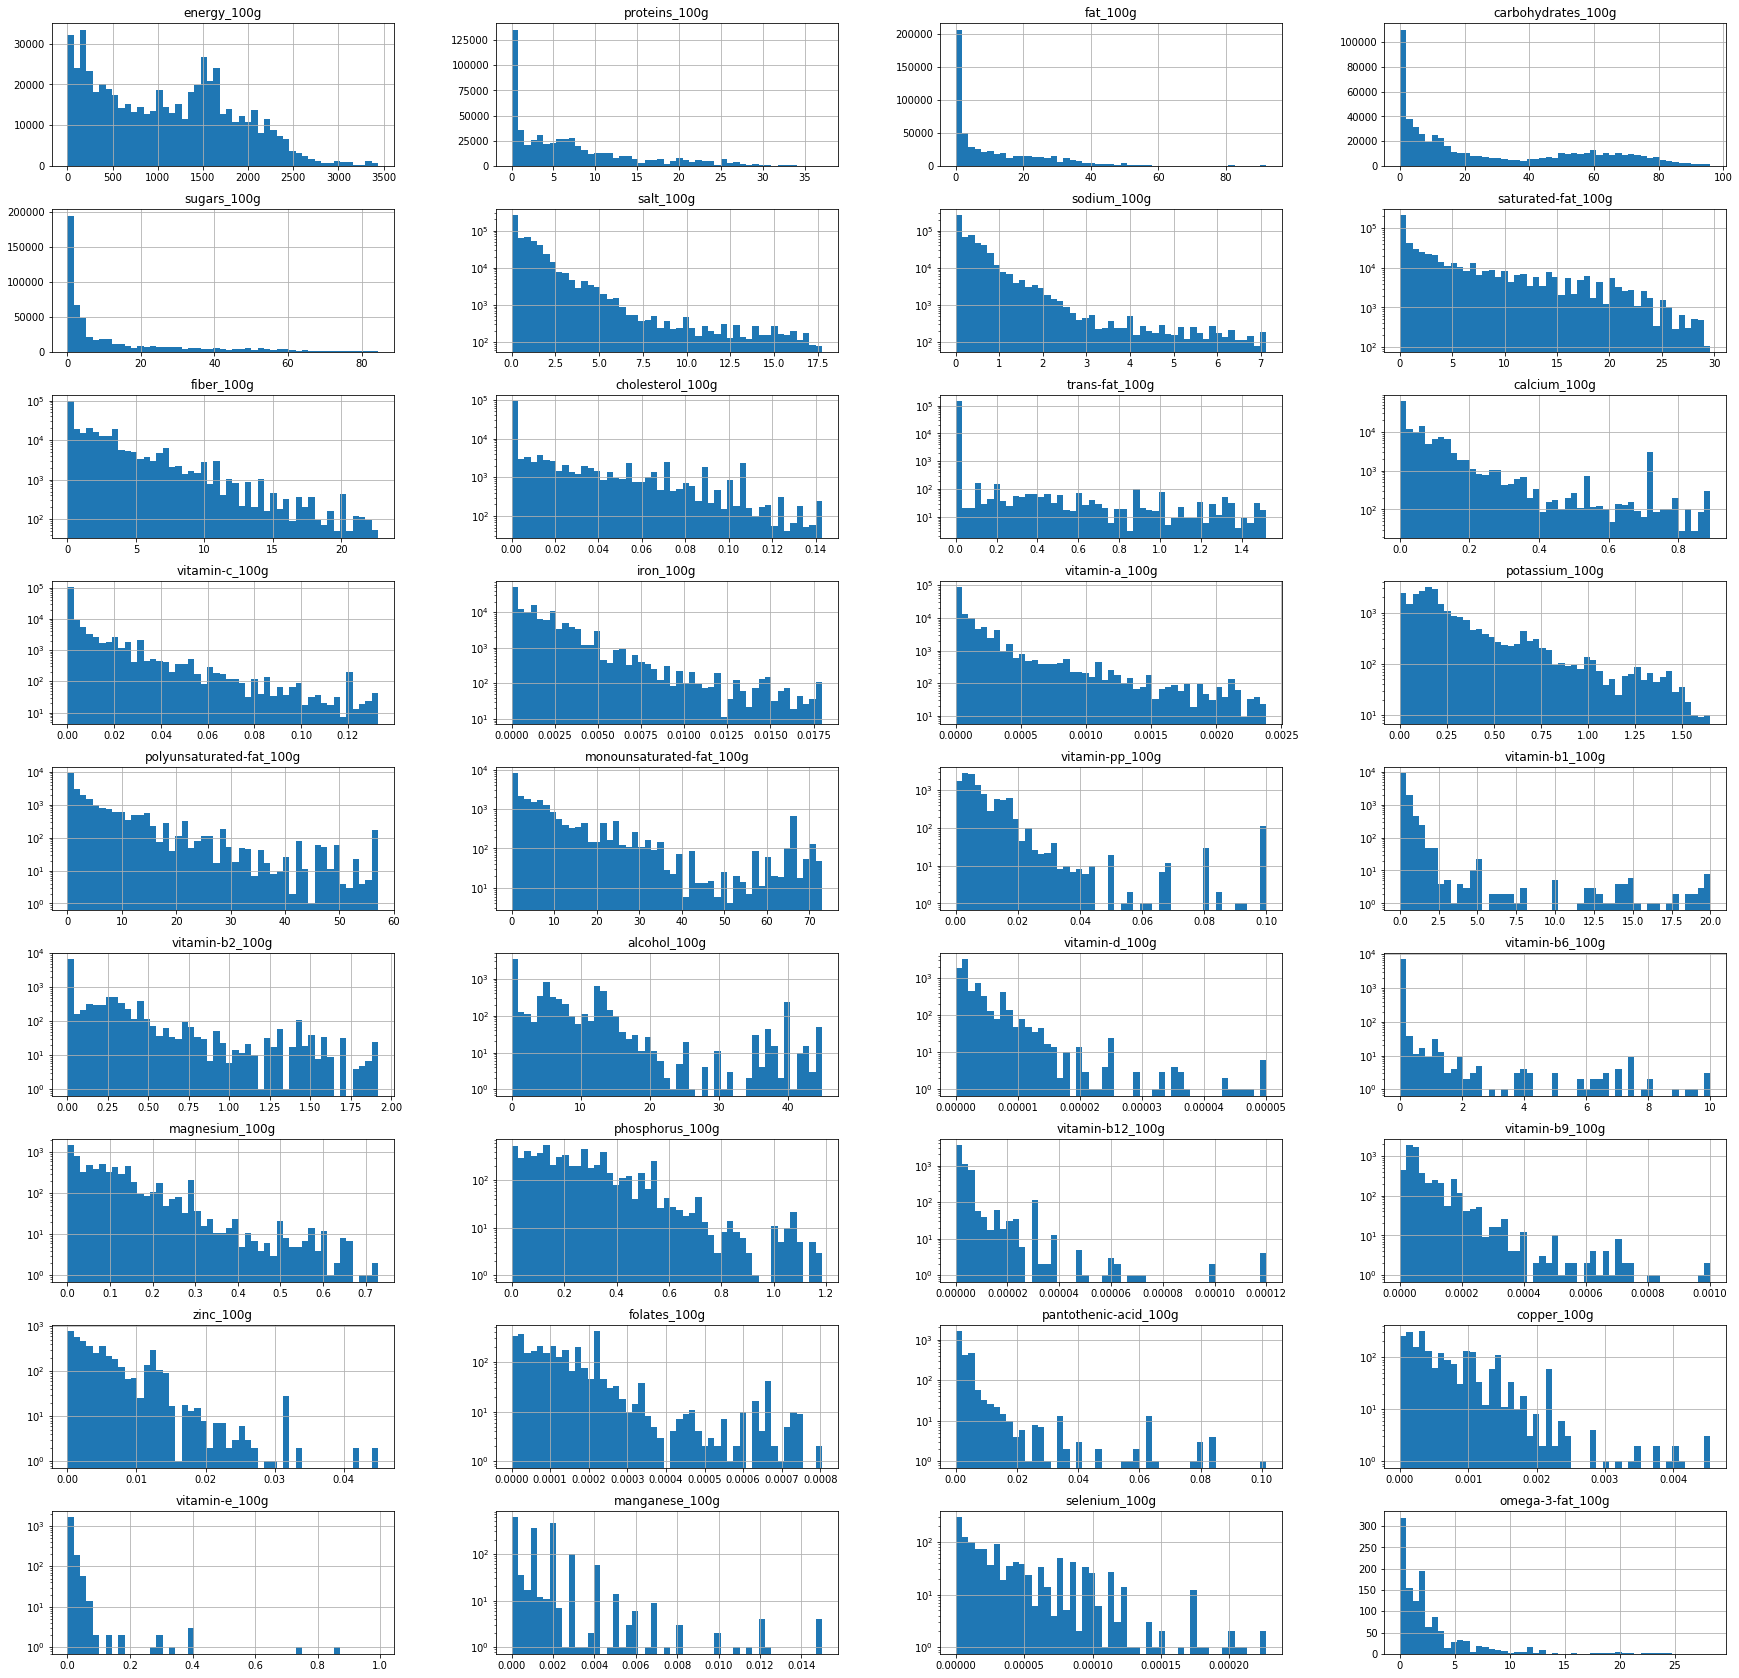

In [28]:
plot_distributions_nutrition(nutrition_facts_filt, nlog_scale_col=['energy_100g', 'proteins_100g', 'fat_100g',
                                                                  'carbohydrates_100g', 'sugars_100g', 'omega-3-fat_100g'])

In [29]:
# If a nutrition value is not mentioned on the label (NaN), we can assume that the nutrient is absent in the food item.
# Thus we replace all NaN with 0. This is because in the absence of any nutrition value, we have no way to know if the product
# actually has that nutrient. For the outlier products, our proposed solution of recommending alternate food product
# based on nutrients (for allergies and additives) can give wrong results. But we see that this problem even arises with OpenFood
# website that calcultes nutri-score wrong if outliers are present.
def remove_nan_values(df):
    df[df.columns.drop('energy_100g')] = df[df.columns.drop('energy_100g')].replace(np.NaN, 0)
    return df

nutrition_facts_filt = remove_nan_values(nutrition_facts_filt)

In [30]:
nutrition_facts_filt[nutrition_facts_filt.energy_100g.isna()].shape

(6423, 36)

In [31]:
# We Observe that there are 6424 products with unknown energy_100g. So, for these products we can calculate approximate energy
# by protein_100g*17 + fat_100g*37 + carbohydrate_100g*17 + fibre_100g*8 + alcohol_100g*29
# source: http://www.mydailyintake.net/energy/

def remove_energy_nan(df):
    na_mask = df['energy_100g'].isna()
    df.loc[df.index[na_mask], 'energy_100g'] = \
                        17*(df[na_mask].proteins_100g + df[na_mask].carbohydrates_100g) +\
                        37*df[na_mask].fat_100g + 8*df[na_mask].fiber_100g + 29*df[na_mask].alcohol_100g
    return df

In [32]:
nutrition_facts_filt = remove_energy_nan(nutrition_facts_filt)

In [33]:
# Save the data as csv file
nutrition_facts_filt.to_csv('Nutrients_Food_Facts_Processed.csv')

Now lets do some research on how ingredients text and allergens are like and what transformation do we need to perform for each one of them

In [127]:
# Getting all the data where ingredients text and allergens are applicable
food_allergens_mask = food_facts_data["ingredients_text"].notnull() & food_facts_data["allergens"].notnull()
food_allergens = food_facts_data[food_allergens_mask]

In [128]:
print("The total number of products is: {}".format(food_facts_data.shape[0]))
print("The total number of products with food allergens ando ingredients data is: {}".format(food_allergens.shape[0]))

# This is approximately 10% of the dataset and hence we have more training data then carbon footprint 

The total number of products is: 699050
The total number of products with food allergens ando ingredients data is: 68601


In [129]:
# Get the language for a particular food / allergen product - as to which language is it written in
def detect_language(phrase):
    try:        
        if not phrase:
            return 'No language'
        
        language_id = detect(phrase)
        return language_id
    except:
        pass

In [130]:
food_allergens['language_id'] = food_allergens["ingredients_text"][:2000].apply(lambda x: detect_language(x))

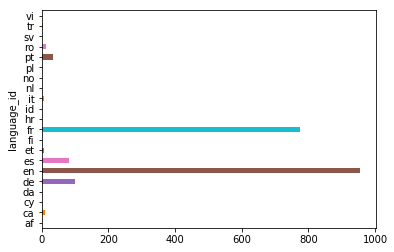

In [131]:
# So we are taking the first 2000 samples to see how many languages are there
# As, we can see there are 22 languages for ingredients_text which is a very difficult translation task in its own!
food_allergens.groupby('language_id').count()['url'].plot.barh()
food_allergens = food_allergens.drop(columns=["language_id"])

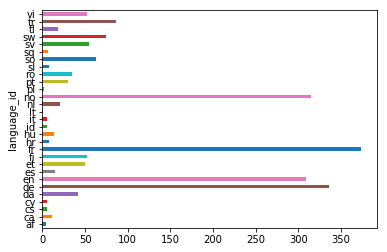

In [132]:
# Now trying to find the number of languages present in the allergens column
food_allergens['language_id'] = food_allergens["allergens"][:2000].apply(lambda x: detect_language(x))
food_allergens.groupby('language_id').count()['url'].plot.barh()
food_allergens = food_allergens.drop(columns=["language_id"])

In [133]:
allergens_dict = {}
    
with open("original_allergens.txt") as f, open("english_allergens.txt") as f2:
    for x, y in zip(f, f2):
        allergens_dict[re.sub(' +', ' ', x).lower().replace('\n', '')] = re.sub(' +', ' ', y).lower().replace('\n', '')

In [134]:
def split_string_to_list(phrase, match_dict=None):
    # Sometimes the word has a incorrect language tag in front of it
    # So we are removing all tags and using language detection instead
    foods = []

    for food in phrase.split(','):
        food = food.strip().rstrip()
        
        # Delete all additives since additives are nearly defined for the whole dataset
        food = re.sub(' +', ' ', food).lower()
        food = re.sub(r"[^A-Za-zàâçéèêëîïôûùüÿñæœ\'\s,]", '', food)
        
        # or food items which are made up of one characters
        if(len(food) <= 2):
            continue
        
        # Split the tag - en, fr if they have it
        formatted_food = food.split(':')[1] if ':' in food else food
    
        if match_dict and formatted_food in match_dict:
            translated_food = match_dict[formatted_food]
        else:
            translated_food = formatted_food
        foods.append(translated_food)
    return foods

In [135]:
# Transferring all french allergens or allergens in any other language to the english language from the translated files we have
food_allergens['allergens'] = food_allergens['allergens'].apply((lambda x: split_string_to_list(x, match_dict=allergens_dict)))

In [136]:
food_allergens['allergens'] = food_allergens['allergens'].apply(frozenset) # Removing all the duplicates from each of the product
unique_allergens = frozenset.union(*food_allergens['allergens'])

print("The total number of food allergens before cleaning them for less than 5 products: {}".format(len(unique_allergens)))

The total number of food allergens before cleaning them for less than 5 products: 3237


In [137]:
# Now we get the allergy count for each of the allergies which are present in more than 5 products
allergen_count = {}
temp_allergens = list(unique_allergens)

# Calculating the allergens and removing the allergens which are present in less than 5 products
for allergen in unique_allergens:
    count = food_allergens['allergens'].apply(lambda x: int(allergen in x)).sum()
    
    # Remove allergen if it is present in less than 5 products
    if count < 5:
        temp_allergens.remove(allergen)
        continue
    allergen_count[allergen] = count

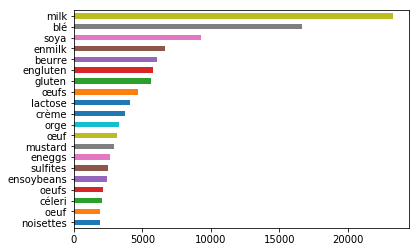

In [138]:
pd.Series(allergen_count).sort_values()[-20:].plot.barh() # Plotting the top most 20 allergens in the dataset

In [139]:
print('Total number of allergens after cleaning them by considering them for greater than 5 products: {}'.format(
    len(allergen_count.keys())))

Total number of allergens after cleaning them by considering them for greater than 5 products: 693


In [140]:
# Take the intersection of all allergens which coexist with 
allergen_set = frozenset(allergen_count.keys())
food_allergens['allergens'] = food_allergens['allergens'].apply(lambda x: allergen_set.intersection(x))

In [141]:
temp_allergens_df = pd.DataFrame(pd.np.empty((food_allergens.shape[0],len(allergen_set))) * 0, columns=allergen_count.keys(), index=food_allergens.index) 

In [142]:
food_allergens['allergens'] = food_allergens.allergens.apply(list)

In [147]:
# Making one hot encoding labels for each of the allergen we need to consider in the dataset
for index in food_allergens.index:
    temp_allergens_df.loc[index, food_allergens.loc[index].allergens] = 1

In [151]:
food_allergens = pd.concat([food_allergens, temp_allergens_df], axis=1)

In [152]:
food_allergens.head() # we can see that dummy features have been added at the end of the dataset

,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,...,brochet,co-founder,a mixture,celerant,hafervollkornflocken,mustards,caséinates,oatmeal,yogourt,macadamia nuts
code,,,,,,,,,,,,,,,,,,,,,
0000000001199,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1517833594,2018-02-05T12:26:34Z,1540674511,2018-10-27T21:08:31Z,Solène céréales poulet,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0000000002264,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1518439960,2018-02-12T12:52:40Z,1518439971,2018-02-12T12:52:51Z,Baguette Poitevin,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0000000003827,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1518691473,2018-02-15T10:44:33Z,1518691490,2018-02-15T10:44:50Z,Suedois saumon,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0000000004794,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1519037756,2018-02-19T10:55:56Z,1520505873,2018-03-08T10:44:33Z,Fromage blanc à la creme de marron,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0000000005272,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1517999700,2018-02-07T10:35:00Z,1517999714,2018-02-07T10:35:14Z,Sandwich solene céréales sicilien,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [153]:
# Splitting and flattening the ingredients text to see how many unique ingredients are there in  the total dataset
food_allergens['ingredients_text'] = food_allergens['ingredients_text'].apply((lambda x: split_string_to_list(x)))
food_allergens['ingredients_text'] = food_allergens['ingredients_text'].apply(frozenset) # Removing all the duplicates from each of the product
unique_ingredients = frozenset.union(*food_allergens['ingredients_text'])

print("The total number of unique ingredients in the dataset are: {}".format(len(unique_ingredients)))

The total number of unique ingredients in the dataset are: 186516


Since, there are 186516 features which are 60 times more than the number of unique allergens (approx 3000). We will need to group these ingredients together under the same umbrella. For this, we are going to go through each of the unique ingredients datasets and get only nouns out from them, and then use word2vec and nltk libraries to group similar ingredients under the higher level ingredient. 

We haven't pursued this task since for this we would need to train a model on all ingredients and this comes under feature engineering and modelling aspect which we will pursue for Milestone 3.